# SD212: Graph mining
## Lab 7: Graph embedding

You will learn how to embed the nodes of a graph in some low-dimensional space using the spectral decomposition of the Laplacian.

## Import

In [1]:
import networkx as nx

import numpy as np

import scipy.sparse as sp

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# %matplotlib notebook

**Hint:** To get the documentation on a `function` you can type `function?`

In [7]:
nx.to_scipy_sparse_matrix?

## Data

You will need the following datasets (the same as in previous labs, no need to download them again):
* [Les Misérables](http://perso.telecom-paristech.fr/~bonald/graphs/miserables.graphml.gz)<br>  Graph connecting the characters of the [novel of Victor Hugo](https://fr.wikisource.org/wiki/Les_Misérables) when they appear in the same chapter. The graph is undirected and weighted. Weights correspond to the number of chapters in which characters appear together. 
* [Openflights](http://perso.telecom-paristech.fr/~bonald/graphs/openflights.graphml.gz)<br>
Graph of the main international flights. Nodes are airports. The graph is undirected (all flights are bidirectional). Weights correspond to the number of daily flights between airports. Extracted from [Openflights](http://openflights.org).
* [Wikipedia for schools](http://perso.telecom-paristech.fr/~bonald/graphs/wikipedia_schools.graphml.gz)<br> Graph of the hyperlinks between a subset of the pages of the English Wikipedia. The graph is directed and unweighted.
More information [here](https://en.wikipedia.org/wiki/Wikipedia:Wikipedia_for_Schools).

## 1. Random walk

Consider an undirected graph of $n$ nodes with adjacency matrix $A$. 
Let $D = \text{diag}(w)$ be the diagonal matrix of node weights, with $w = A1$.
The transition matrix of the random walk is defined by $P = D^{-1}A$. This is a stochastic matrix.

## Toy graph

Consider the following graph:

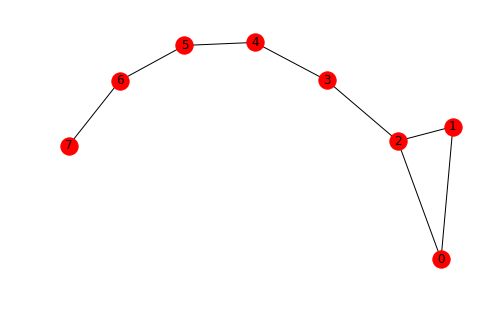

In [2]:
graph = nx.lollipop_graph(3, 5)
nx.draw(graph, with_labels = True)

In [3]:
adjacency = nx.to_scipy_sparse_matrix(graph)

In [4]:
def transition_matrix(adjacency):
    n = adjacency.shape[0]
    weights = adjacency.dot(np.ones(n))
    inverse_weight_matrix = sp.diags(1 / weights, format='csr')
    return inverse_weight_matrix.dot(adjacency)

In [5]:
P = transition_matrix(adjacency)

In [6]:
n = adjacency.shape[0]

In [7]:
# Stochastic matrix
P.dot(np.ones(n))

array([1., 1., 1., 1., 1., 1., 1., 1.])

## To do

* Complete the function `random_walk` below that compute the distribution of the random walk after `N` steps.
* Check the convergence to the stationary distribution on the above toy graph (e.g., starting from the uniform distribution).

In [8]:
def random_walk(adjacency, start, N = 10):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    start: np array
        initial distribution (sums to 1)
    N: int
        number of steps
        
    Returns: np array
        distribution after N steps
    '''    
    distribution = start
    # to be completed
    
    # Pi_t+1 = P*Pi_t
    
    P = transition_matrix(adjacency)
    
    for i in range(N):
        distribution = P.dot(distribution)
    
    return distribution

## 2. Laplacian

The Laplacian matrix is defined by:
$$
L = D - A.
$$

In [9]:
def laplacian_matrix(adjacency):
    n = adjacency.shape[0]
    weights = adjacency.dot(np.ones(n))
    weight_matrix = sp.diags(weights, format='csr')
    return weight_matrix - adjacency

In [10]:
L = laplacian_matrix(adjacency)

In [11]:
n = adjacency.shape[0]

In [12]:
L.dot(np.ones(n))

array([0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
L

<8x8 sparse matrix of type '<class 'numpy.float64'>'
	with 24 stored elements in Compressed Sparse Row format>

## Heat equation

The Laplacian is related to a diffusion process on the graph governed by the heat equation,
$$
\forall i\not \in S, \quad  \frac{dT_i}{dt} = -(LT)_i,
$$
where $T_i$ be the temperature of node $i$ and $S$ the boundary where temperature is fixed. 

The solution satisfies:
$$
\forall i\not \in S, \quad(LT)_i = 0,
$$
or equivalently,
$$
\forall i\not \in S, \quad T_i = (PT)_i.
$$

This is the [Dirichlet problem](https://en.wikipedia.org/wiki/Dirichlet_problem).
The easiest way to compute the solution to the Dirichlet problem is to use the diffusion in discrete time:
$$
\forall i\not \in S, \quad T_i \gets (PT)_i.
$$


## To do

* Complete the `diffusion` function below that returns the temperature of each node after $N$ iterations of the  diffusion in discrete time, when the boundary set $S$ consists of two sets of nodes: the `sources` at temperature 0 and the `targets` at temperature 1. 
* Show the heat map of the above toy graph, for one source and one target of your choice. You may print the vector $LT$.
* Show the heat map of Les Miserables after the diffusion from Cosette and Fantine (sources) to Marius (target). What is the hotest node after Marius?
* Show the heat map of Openflights after the diffusion from Charles-de-Gaulle Airport (source) to Beijing Capital International Airport (target). 
* Display the 5 hotest pages of Wikipedia for Schools (considered as undirected) after diffusion from Cat to Dog. Compare with the 5 top-pages for the  Personalized PageRank associated to Dog.

In [14]:
def diffusion(adjacency, sources, targets, N = 100, verbose=False):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    sources: list of int
        nodes at temperature 0
    targets: list of int
        nodes at temperature 1
    N: int
        number of steps
        
    Returns: np array
        temperature after N steps
    '''    
    n = adjacency.shape[0]
    T = 0.5 * np.ones(n, float)
    sources = np.array(sources)
    targets = np.array(targets)
    
    ind = list(range(n))
    ind.remove(sources)
    ind.remove(targets)
    
    T[sources] = 0
    T[targets] = 1
    
    # to be completed
    P = transition_matrix(adjacency)
    
    for i in range(N):
        T[ind] = P.dot(T)[ind]
    
    L = laplacian_matrix(adjacency=adjacency)
    
    if verbose:
        print(L.dot(T))
    
    return T

In [15]:
n = adjacency.shape[0]
T = diffusion(adjacency, [0], [n-1], verbose=True)

[-1.76470598e-01  3.58703572e-09 -3.81096199e-09  1.21979454e-08
 -6.09897266e-09  1.30639620e-08 -3.15402737e-09  1.76470582e-01]


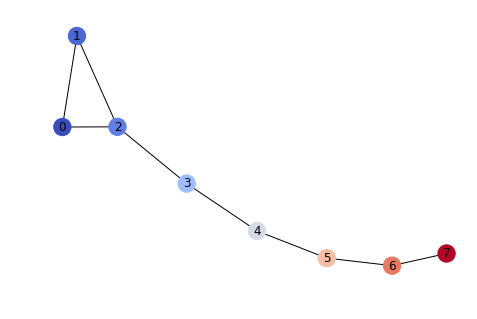

In [16]:
plt.figure()
nx.draw(graph, with_labels = True, node_color = T, cmap = 'coolwarm')

In [17]:
miserables = nx.read_graphml("miserables.graphml", node_type = int)
adjacency_miserable = nx.to_scipy_sparse_matrix(miserables)

In [18]:
name = nx.get_node_attributes(miserables, 'name')
name_miserable = np.array([kv[1] for kv in name.items()])
# name_miserable

In [19]:
cosette = 26
fantine = 23
marius = 55

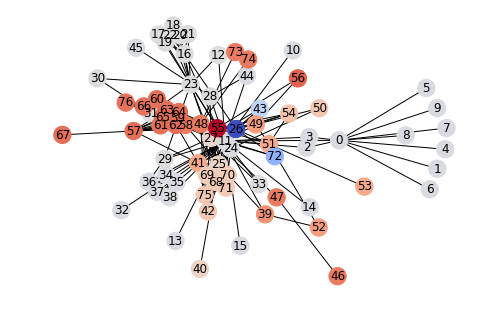

In [20]:
T_miserable = diffusion(adjacency_miserable, [cosette], [marius])
plt.figure()
nx.draw(miserables, with_labels = True, node_color = T_miserable, cmap = 'coolwarm')

In [27]:
openflights = nx.read_graphml("openflights.graphml", node_type = int)

In [28]:
# Get positions
pos_x = nx.get_node_attributes(openflights,'pos_x')
pos_y = nx.get_node_attributes(openflights,'pos_y')
pos = {u: (pos_x[u], pos_y[u]) for u in openflights.nodes()}

In [29]:
name = nx.get_node_attributes(openflights, 'name')

In [30]:
cdg = 622
beijing = 1618

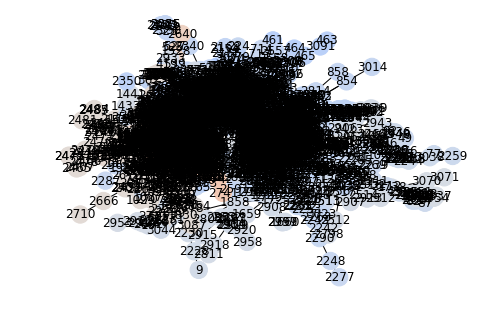

In [31]:
adjacency_openflights = nx.to_scipy_sparse_matrix(openflights)
T_openflights = diffusion(adjacency_openflights, [cdg], [beijing])
plt.figure()
nx.draw(openflights, with_labels = True, node_color = T_openflights, cmap = 'coolwarm')

In [34]:
wikipedia = nx.read_graphml("wikipedia_schools.graphml", node_type = int).to_undirected()

In [41]:
name = nx.get_node_attributes(wikipedia, 'name')
name_wiki = np.array([kv[1] for kv in name.items()])

In [40]:
dog = 1408
cat = 2515

In [42]:
adjacency_wiki = nx.to_scipy_sparse_matrix(wikipedia)
T_wiki = diffusion(adjacency_wiki, [dog], [cat])

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000225EB7DE268> (for post_execute):


KeyboardInterrupt: 

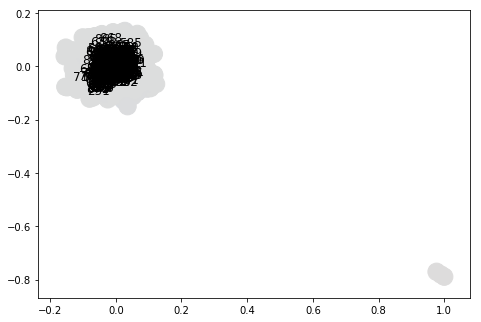

In [82]:
plt.figure()
nx.draw(wikipedia, with_labels = True, node_color = T_wiki, cmap = 'coolwarm')

## 3. Spectral embedding

Let $v_1,\ldots,v_n$ be the eigenvectors of the Laplacian matrix, with corresponding eigenvalues $\lambda_1= 0 < \lambda_2 \le  \ldots \le \lambda_{n}$. The spectral embedding of the graph in dimension $k$ is given by the following $n\times k$ matrix:
$$
X = \left(\frac {v_2} {\sqrt{\lambda_2}},\ldots,\frac {v_{k+1}} {\sqrt{\lambda_{k+1}}}\right)^T.
$$

In [21]:
def spectral_decomposition_laplacian(adjacency, number = None):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    number: int
        number of eigenvalues / eigenvectors
        
    Returns: (np array, np.array)
        eigenvalues, eigenvectors of the Laplacian matrix
    '''    
    n = adjacency.shape[0]
    if number == None or number >= n: # full spectrum
        number = n - 1
    laplacian = laplacian_matrix(adjacency)
    eigenvalues, eigenvectors = sp.linalg.eigsh(laplacian, number, sigma = -1)
    index = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[index]
    eigenvectors = eigenvectors[:,index]
    return eigenvalues, eigenvectors 

## To do 

* Plot the spectrum of the Laplacian matrix associated with the toy graph, as well as the heat map of the graph associated with the Fiedler vector $v_2$
* Complete the function `spectral_embedding` below that returns the spectral embedding $X$

In [23]:
def spectral_embedding(adjacency, k = 10):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    k: int
        dimension of the embedding
        
    Returns: np array
        spectral embedding (based on the Laplacian)
    '''    
    n = adjacency.shape[0]
    X = np.zeros((n,k))
    # to be completed
    eigenvalues, eigenvectors = spectral_decomposition_laplacian(adjacency, number = k+1)
    
#    for i in range(1,k):
#        X[:,i] = eigenvectors[:,i]/np.sqrt(eigenvalues[i])
    
    # All rows, without the first column
    X = eigenvectors[:,1:]/np.sqrt(eigenvalues[1:])
    
    return X

* Display the 2D embedding of the toy graph

In [25]:
eigenvalues, eigenvectors = spectral_decomposition_laplacian(adjacency, number = 2)

In [26]:
eigenvalues

array([0.        , 0.16671701])

In [27]:
eigenvectors[:,1]

array([ 0.40530072,  0.40530072,  0.33773019,  0.14628378, -0.06955063,
       -0.27378976, -0.43238349, -0.51889153])

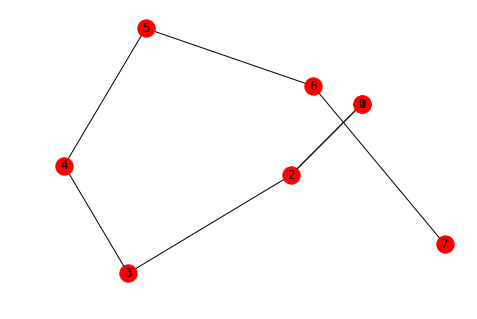

In [28]:
X = spectral_embedding(adjacency, k=3)
plt.figure()
nx.draw(graph, with_labels = True, pos=X[:,1:], cmap = 'coolwarm')

Plot avec pos = X ou Scatter

* Display the 2D embedding of Les Miserables (with names)

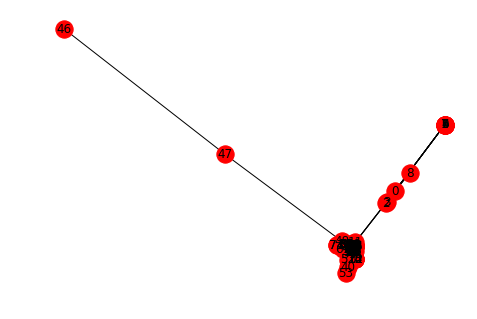

In [29]:
X_miserable = spectral_embedding(adjacency_miserable, k=10)
plt.figure()
nx.draw(miserables, with_labels = True, pos=X_miserable[:,:2], cmap = 'coolwarm')

* List the 5 closest nodes from Marius in terms of cosine similarity in the embedding of Les Miserables in dimension 10.

In [30]:
def get_cosine_similarity(X, node):
    '''
    X: np array
        embedding
    node: int
        target node
        
    Returns: np array
        cosine similarity with all other nodes
    '''        
    cosine = X.dot(X[node,:]) / np.linalg.norm(X, axis = 1) / np.linalg.norm(X[node,:])
    return cosine

In [31]:
cosine_miserable = get_cosine_similarity(X_miserable, 55)
closest_node_to_marius = np.argsort(cosine_miserable)[::-1]
closest_names_to_marius = name_miserable[closest_node_to_marius[:5]]
closest_names_to_marius

array(['Marius', 'Magnon', 'Cosette', 'Eponine', 'Enjolras'], dtype='<U17')

## To do

* Plot the 10 first eigenvalues of the Laplacian associated with Wikipedia for Schools. What do you observe?

In [35]:
adjacency_wiki = nx.to_scipy_sparse_matrix(wikipedia)
eigenvalue, eigenvectors = spectral_decomposition_laplacian(adjacency=adjacency_wiki, number=10)
eigenvalue

array([-1.99840144e-15,  0.00000000e+00,  8.72090385e-01,  9.70811028e-01,
        9.76413967e-01,  9.76846473e-01,  9.83403267e-01,  9.86132314e-01,
        9.89374556e-01,  9.92136262e-01])

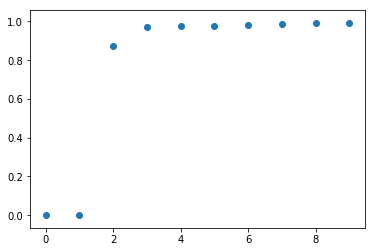

In [37]:
plt.scatter([i for i in range(len(eigenvalue))],eigenvalue)

* List the 10 closest nodes from Dog in terms of cosine similarity in the embedding of Wikipedia for Schools in dimension 50. Redo the experiment after removing the first component of the embedding. Interpret the results.

In [43]:
X_wiki = spectral_embedding(adjacency_wiki, k=50)
X_wiki

array([[ 1.33142037e+05, -3.88619862e-04, -2.19732671e-04, ...,
        -1.06680064e-04,  4.75722122e-04,  4.92281558e-04],
       [ 1.33142037e+05, -3.66609328e-04, -2.18159489e-04, ...,
        -8.83438155e-05,  4.06768821e-04,  3.73434286e-04],
       [ 1.33142037e+05, -3.72664437e-04, -2.09679848e-04, ...,
        -9.97026928e-05,  4.30988783e-04,  4.33375255e-04],
       ...,
       [ 1.33142037e+05, -6.26251507e-04, -3.70357893e-04, ...,
         5.29599654e-03, -2.03452270e-02, -1.09120649e-03],
       [ 1.33142037e+05, -4.56011490e-04, -2.39450787e-04, ...,
        -1.84892206e-04,  7.68801612e-04,  1.07270353e-03],
       [ 1.33142037e+05, -4.06440015e-04, -2.29855059e-04, ...,
         3.25351815e-04,  4.02546910e-04,  5.77477647e-04]])

In [44]:
cosine_wiki = get_cosine_similarity(X_wiki, dog)
closest_to_dog = np.argsort(cosine_wiki)[::-1]
closest_name_to_dog = name_wiki[closest_to_dog]
closest_name_to_dog

array(['Zara Yaqob', 'Mining', "Lord's Resistance Army", ...,
       'Pere Marquette 1225', "Klinefelter's syndrome",
       'Duchenne muscular dystrophy'], dtype='<U83')

In [45]:
cosine_wiki = get_cosine_similarity(X_wiki[:,1:], dog)
closest_to_dog = np.argsort(cosine_wiki)[::-1]
closest_name_to_dog = name_wiki[closest_to_dog]
closest_name_to_dog

array(['Dog',
       'Convention on the International Trade in Endangered Species of Wild Flora and Fauna',
       'Mountain Gorilla', ..., 'Forth', 'GNU Project', 'InterBase'],
      dtype='<U83')

Another spectral embedding is based on the spectral decomposition of the transition matrix. This amounts to weight each node by its weight in the graph. Let $v_1,\ldots,v_n$ be the eigenvectors of $P$, with corresponding eigenvalues $\lambda_1= 1 > \lambda_2 \ge  \ldots \ge \lambda_{n}$. The weighted spectral embedding of the graph in dimension $k$ is given by the following $n\times k$ matrix:
$$
Y = \left(\frac {v_2} {\sqrt{1-\lambda_2}},\ldots,\frac {v_{k+1}} {\sqrt{1-\lambda_{k+1}}}\right)^T.
$$

## To do

* Complete the functions `spectral_decomposition_transition` and `weighted_spectral_embedding` below. <br>
**Note:** The spectral decomposition of the transition matrix involves the normalized adjacency matrix $D^{-1/2}AD^{-1/2}$ (cf. Theorem 1 in the lecture notes).
* Do the same experiments as above for this new embedding.

In [49]:
def spectral_decomposition_transition(adjacency, number = None):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    number: int
        number of eigenvalues / eigenvectors
        
    Returns: (np array, np.array)
        eigenvalues, eigenvectors of the transition matrix
    '''    
    n = adjacency.shape[0]
    
    if number == None or number >= n: # full spectrum
        number = n - 1
    
#     eigenvalues = np.zeros(k)
#     eigenvectors = np.zeros((n,k))
    # to be completed

    
    
    
    # norm_adjacency = ...
    # eigenvalues, eigenvectors = sp.linalg.eigsh(norm_adjacency, number, which='LA')
    
    transition = transition_matrix(adjacency)
    
    eigenvalues, eigenvectors = sp.linalg.eigsh(transition, number, sigma = -1)
    
    
    index = np.argsort(eigenvalues)
    eigenvalues = eigenvalues[index]
    eigenvectors = eigenvectors[:,index]
    
    return eigenvalues, eigenvectors 

In [47]:
def weighted_spectral_embedding(adjacency, k = 10):
    '''
    adjacency: scipy CSR matrix
        adjacency matrix
    k: int
        dimension of the embedding
        
    Returns: np array
        weighted spectral embedding (based on the transition matrix)
    '''    
    n = adjacency.shape[0]
    Y = np.zeros((n,k))
    # to be completed
    
    eigenvalues, eigenvectors = spectral_decomposition_transition(adjacency, number = k+1)
    
    # All rows, without the first column
    Y = eigenvectors[:,1:]/np.sqrt(1-eigenvalues[1:])
    
    return Y

In [50]:
eigenvalue, eigenvectors = spectral_decomposition_transition(adjacency=adjacency_wiki, number=10)
eigenvalue

array([-0.52508306, -0.50123079, -0.49987239, -0.4075048 , -0.39323795,
       -0.38959996, -0.37550532, -0.37083243, -0.36719558, -0.35890352])

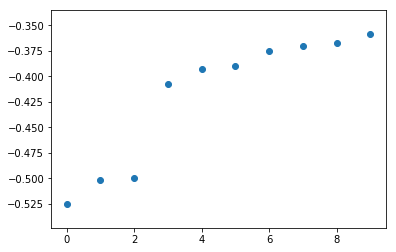

In [51]:
plt.scatter([i for i in range(len(eigenvalue))], eigenvalue)

In [52]:
Y_wiki = weighted_spectral_embedding(adjacency=adjacency_wiki, k=10)

In [54]:
cosine_wiki_2 = get_cosine_similarity(Y_wiki, dog)
closest_to_dog_2 = np.argsort(cosine_wiki_2)[::-1]
closest_name_to_dog_2 = name_wiki[closest_to_dog_2]
closest_name_to_dog_2[:10]

array(['Dog', 'Peafowl', 'Paleontology', 'Permian', 'Red giant',
       'Rook (bird)', 'Woodpecker', 'Tuna', 'Sauropodomorpha',
       'Common Cuckoo'], dtype='<U83')

In [55]:
cosine_wiki_2 = get_cosine_similarity(Y_wiki[:,1:], dog)
closest_to_dog_2 = np.argsort(cosine_wiki_2)[::-1]
closest_name_to_dog_2 = name_wiki[closest_to_dog_2]
closest_name_to_dog_2[:10]

array(['Dog', 'Peafowl', 'Paleontology', 'Permian', 'Rook (bird)',
       'Woodpecker', 'Common Cuckoo', 'Red giant', 'Kestrel', 'Chaffinch'],
      dtype='<U83')